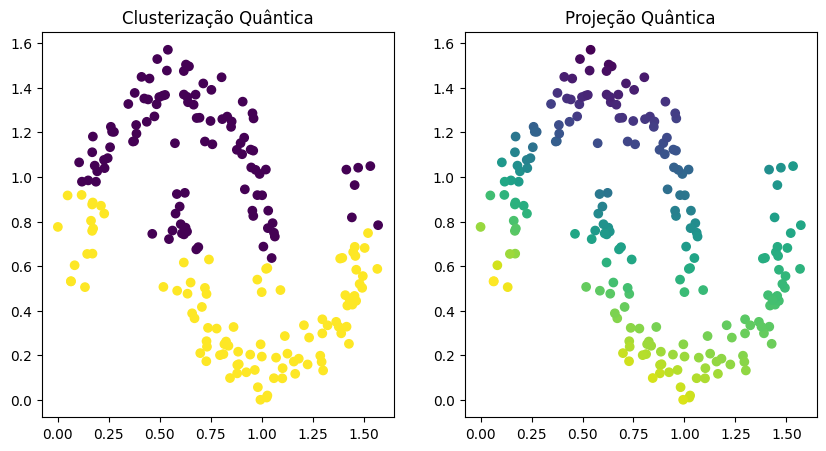

Epoch 0: -0.1823
Epoch 1: -0.3297
Epoch 2: -0.4281
Epoch 3: -0.4900
Epoch 4: -0.5337
Epoch 5: -0.5653
Epoch 6: -0.5890
Epoch 7: -0.6058
Epoch 8: -0.6187
Epoch 9: -0.6265
Epoch 10: -0.6328
Epoch 11: -0.6380
Epoch 12: -0.6437
Epoch 13: -0.6492
Epoch 14: -0.6531
Epoch 15: -0.6576
Epoch 16: -0.6593
Epoch 17: -0.6588
Epoch 18: -0.6596
Epoch 19: -0.6596
Epoch 20: -0.6592
Epoch 21: -0.6590
Epoch 22: -0.6589
Epoch 23: -0.6591
Epoch 24: -0.6593
Epoch 25: -0.6595
Epoch 26: -0.6596
Epoch 27: -0.6597
Epoch 28: -0.6599
Epoch 29: -0.6600
Epoch 30: -0.6603
Epoch 31: -0.6606
Epoch 32: -0.6610
Epoch 33: -0.6614
Epoch 34: -0.6619
Epoch 35: -0.6623
Epoch 36: -0.6628
Epoch 37: -0.6632
Epoch 38: -0.6636
Epoch 39: -0.6641
Epoch 40: -0.6645
Epoch 41: -0.6649
Epoch 42: -0.6653
Epoch 43: -0.6657
Epoch 44: -0.6660
Epoch 45: -0.6664
Epoch 46: -0.6667
Epoch 47: -0.6670
Epoch 48: -0.6672
Epoch 49: -0.6675
Epoch 50: -0.6677
Epoch 51: -0.6679
Epoch 52: -0.6681
Epoch 53: -0.6683
Epoch 54: -0.6685
Epoch 55: -0.6686
Ep

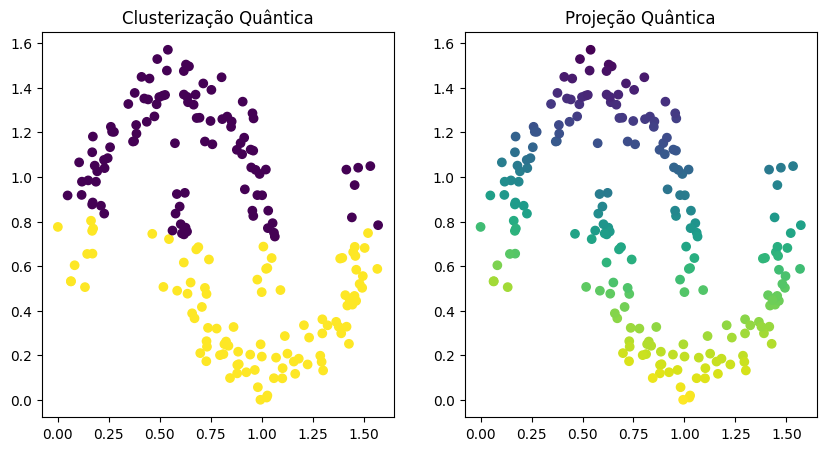

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import operator

# 1. Gerar e preparar dados
X, _ = make_moons(n_samples=200, noise=0.1, random_state=42)
X = MinMaxScaler(feature_range=(0, np.pi/2)).fit_transform(X)  # Normalizar para [0, π/2]

# 2. Definir circuito quântico variacional
n_qubits = 4
n_entanglement = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(x, weights):
    wires = range(n_qubits)
    # Camada de codificação de dados
    # Codificação não linear via rotações combinadas
    qml.AngleEmbedding(x, wires=wires, rotation='Y')  # Codificação básica
    qml.Rot(x[0], x[1], x[0]+x[1], wires=wires[0])  # Combinação não linear
    qml.CRX(x[0] * x[1], wires=[wires[0], wires[1]])  # Entrelaçamento dependente dos dados
    
    for i in range(4):  # Agora para 4 qubits
        qml.Rot(weights[i][0], weights[i][1], weights[i][2], wires=i)
    
    # Padrão de entrelaçamento dinâmico para 4 qubits
    for i in range(2):  # Dois pares por camada
        # Alternância baseada no número da camada e índice
        if (i + n_entanglement) % 2 == 0:
            # Primeiro modo de entrelaçamento (horizontal)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[1, 2])
        else:
            # Segundo modo de entrelaçamento (cruzado)
            qml.CNOT(wires=[0, 3])
            qml.CNOT(wires=[3, 1])
            qml.CNOT(wires=[1, 2])
        
        # Entrelaçamento adicional para camadas profundas
        if n_entanglement > 2:
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
    
    # return qml.expval(reduce(operator.matmul, [qml.PauliZ(i) for i in wires]))
    return [qml.expval(qml.PauliZ(i)) for i in wires]

# Transformação não linear via kernel RBF
def rbf_kernel(x1, x2):
    return np.exp(-1 * np.linalg.norm(x1 - x2)**2)

def cost(weights, X):
    # Transformação não linear via circuito quântico
    embeddings = np.array([quantum_circuit(x, weights) for x in X])
    
    # Projeção para obter previsões contínuas
    proj = np.dot(embeddings, weights[0])
    continuous_preds = 2 / (1 + np.exp(-proj)) - 1  # Transformação sigmoide

    # Criação de máscaras para os clusters
    mask_0 = continuous_preds < 0
    mask_1 = continuous_preds >= 0
    
    # Cálculo dos centroides dos embeddings com verificação de clusters vazios
    mean_0 = np.mean(embeddings[mask_0], axis=0) if np.any(mask_0) else np.zeros(embeddings.shape[1])
    mean_1 = np.mean(embeddings[mask_1], axis=0) if np.any(mask_1) else np.zeros(embeddings.shape[1])

    # Cálculo das similaridades RBF
    similarities_0 = np.array([rbf_kernel(emb, mean_0) for emb in embeddings])
    similarities_1 = np.array([rbf_kernel(emb, mean_1) for emb in embeddings])

    # Aplicação de pesos considerando máscaras e similaridades
    weights_0 = np.where(mask_0, similarities_0, 0)
    weights_1 = np.where(mask_1, similarities_1, 0)

    # Cálculo dos centroides ponderados
    centroid_0 = np.sum(continuous_preds * weights_0) / (np.sum(weights_0) + 1e-8)
    centroid_1 = np.sum(continuous_preds * weights_1) / (np.sum(weights_1) + 1e-8)

    # Perda intra-cluster (variância ponderada)
    intra_loss = (
        np.sum(weights_0 * (continuous_preds - centroid_0)**2)/(np.sum(weights_0) + 1e-8) +
        np.sum(weights_1 * (continuous_preds - centroid_1)**2)/(np.sum(weights_1) + 1e-8)
    ) / 2

    # Perda inter-cluster (separação entre clusters)
    inter_loss = -np.abs(np.tanh(centroid_1) - np.tanh(centroid_0))

    return intra_loss + 0.5 * inter_loss

# # 3. Função de custo quântico-clássica
# def cost(weights, X):
#     # Transformação não linear via circuito quântico
#     embeddings = np.array([quantum_circuit(x, weights) for x in X])
    
#     print("Embeddings:", embeddings.shape)
#     print("Pesos:", weights[-1].shape)

#     print(np.dot(embeddings, weights[-1]).shape)
    
#     # Cálculo de similaridade intra-cluster
#     centroid = np.mean(embeddings, axis=0)

#     print(centroid)

#     intra_loss = np.mean(np.linalg.norm(embeddings - centroid, axis=0))
    
#     # Separação inter-cluster
#     proj = np.dot(embeddings, weights[-1])  # Usa últimos pesos como direção de projeção
#     inter_loss = -np.abs(np.mean(proj[:100]) - np.mean(proj[100:]))
    
#     return intra_loss + inter_loss

# 4. Hiperparâmetros e otimização
np.random.seed(42)
weights = np.random.uniform(0, 2*np.pi, size=(4, n_qubits))  # 3 camadas variacionais
opt = qml.NesterovMomentumOptimizer(stepsize=0.1)


# 5. Visualização dos clusters
final_embeddings = np.array([quantum_circuit(x, weights) for x in X])
projection = np.dot(final_embeddings, weights[0])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=projection > np.median(projection), marker='o')
plt.title("Clusterização Quântica")
plt.subplot(122)
plt.scatter(X[:,0], X[:,1], c=projection, cmap='viridis', marker='o')
plt.title("Projeção Quântica")
plt.show()

for epoch in range(100):
    weights, current_cost = opt.step_and_cost(cost, weights, X=X)
    # if epoch % 10 == 0:
    print(f"Epoch {epoch}: {current_cost:.4f}")

# 5. Visualização dos clusters
final_embeddings = np.array([quantum_circuit(x, weights) for x in X])
projection = np.dot(final_embeddings, weights[0])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=projection > np.median(projection), marker='o')
plt.title("Clusterização Quântica")
plt.subplot(122)
plt.scatter(X[:,0], X[:,1], c=projection, cmap='viridis', marker='o')
plt.title("Projeção Quântica")
plt.show()

In [11]:
weights[-1].shape

(4,)

In [10]:
final_embeddings.shape

(200, 4)

In [12]:
np.dot(final_embeddings, weights[-1]).shape

(200,)

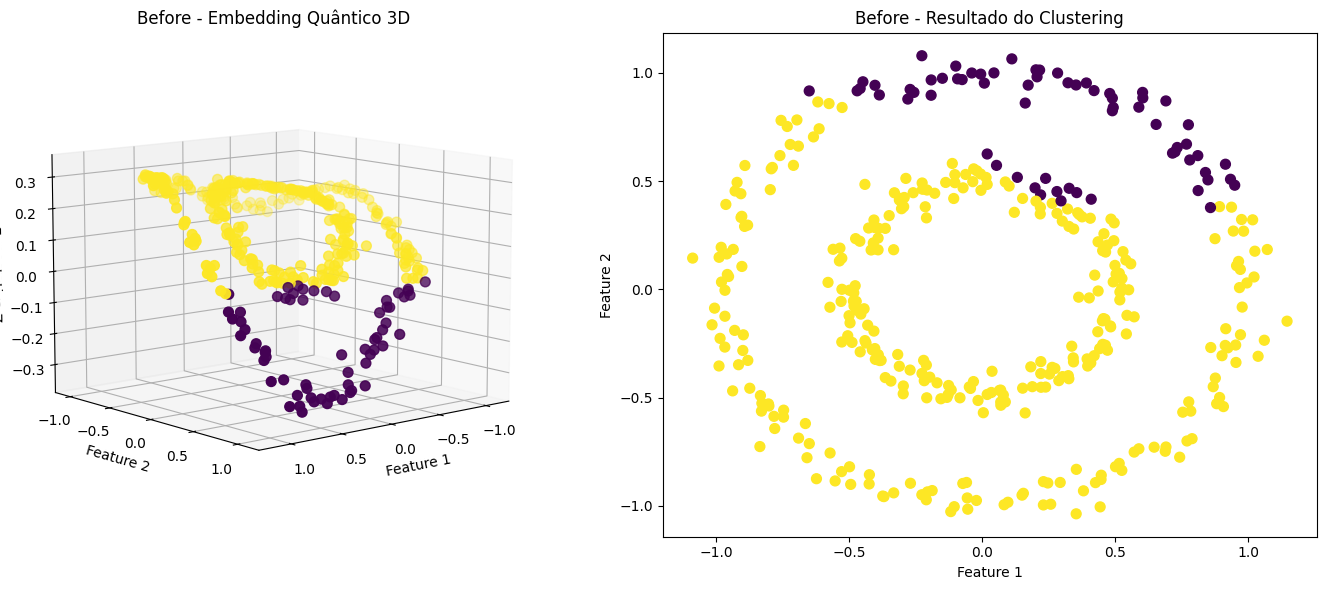

Passo 0: Custo = -0.0868
Passo 10: Custo = -0.1085
Passo 20: Custo = -0.1359
Passo 30: Custo = -0.1619
Passo 40: Custo = -0.1846
Passo 50: Custo = -0.2029
Passo 60: Custo = -0.2180
Passo 70: Custo = -0.2296
Passo 80: Custo = -0.2378
Passo 90: Custo = -0.2444


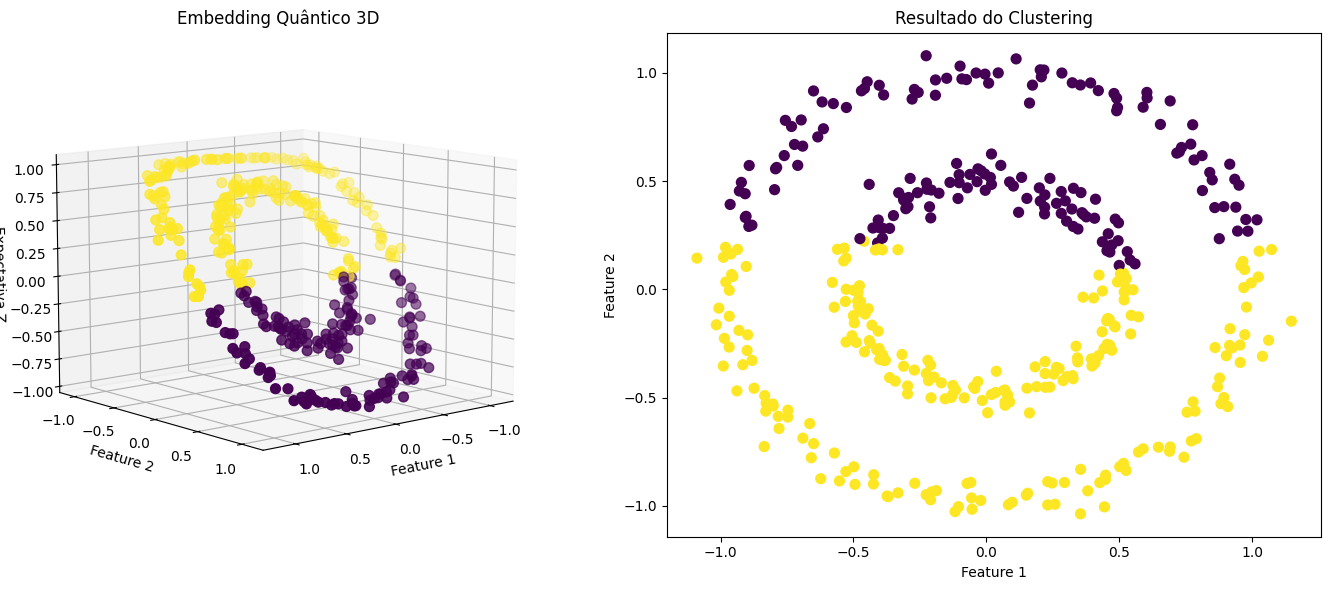

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.preprocessing import MinMaxScaler

# Gerar dataset
# X, y = make_blobs(n_samples=200, centers=2, random_state=42)
X, y = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# Configuração do circuito quântico
n_qubits = 4
n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev)
def circuito(features, params):
# Circuito quântico variacional (QAOA-inspired)
    # Codificação dos dados de entrada
    for qubit in range(n_qubits):
        qml.Hadamard(wires=qubit)
        qml.RY(features[qubit % len(features)], wires=qubit)
    
    # Camadas variacionais
    for layer in range(n_layers):
        for qubit in range(n_qubits):
            qml.Rot(params[layer][qubit][0], 
                    params[layer][qubit][1], 
                    params[layer][qubit][2], wires=qubit)
        # Entrelaçamento
        for qubit in range(n_qubits-1):
            qml.CNOT(wires=[qubit, qubit+1])
            
    # Medida primeiro qubit
    return qml.expval(qml.PauliZ(0))

# Inicialização dos parâmetros
params = np.random.uniform(0, 2*np.pi, size=(n_layers, n_qubits, 3), requires_grad=True)  # Mais parâmetros

# Cálculo final das expectativas
expectativas_finais = np.array([circuito(x, params) for x in X_scaled])
# Atribuir clusters com base nas expectativas
continuous_preds = 2 / (1 + np.exp(-expectativas_finais)) - 1
rotulos_preditos = continuous_preds > 0

# Plotar resultados
fig = plt.figure(figsize=(14, 6))

# Plot 3D do embedding
ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(X[:,0], X[:,1], expectativas_finais, 
                c=rotulos_preditos, cmap='viridis', s=50)
ax1.set_title("Before - Embedding Quântico 3D")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Expectativa Z")
ax1.view_init(elev=10, azim=50)

# Plot do resultado do clustering
ax2 = fig.add_subplot(122)
ax2.scatter(X[:,0], X[:,1], c=rotulos_preditos, cmap='viridis', s=50)
ax2.set_title("Before - Resultado do Clustering")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Função de custo para aprendizado não supervisionado
def custo(params, X):
    raw_outputs = np.array([circuito(x, params) for x in X])
    continuous_preds = 2 / (1 + np.exp(-raw_outputs)) - 1

    # Calculando máscaras para evitar slices vazios
    mask_0 = continuous_preds < 0
    mask_1 = continuous_preds >= 0
    
    # Calculando médias com verificação de arrays vazios
    mean_0 = np.mean(X[mask_0], axis=0) if np.any(mask_0) else np.zeros(X.shape[1])
    mean_1 = np.mean(X[mask_1], axis=0) if np.any(mask_1) else np.zeros(X.shape[1])

    # Calculando similaridades
    similarities_0 = np.array([rbf_kernel(x, mean_0) for x in X])
    similarities_1 = np.array([rbf_kernel(x, mean_1) for x in X])

    # Restante do código permanece igual
    weights_0 = np.where(mask_0, similarities_0, 0)
    weights_1 = np.where(mask_1, similarities_1, 0)

    centroid_0 = np.sum(continuous_preds * weights_0) / (np.sum(weights_0) + 1e-8)
    centroid_1 = np.sum(continuous_preds * weights_1) / (np.sum(weights_1) + 1e-8)

    intra_loss = (
        np.sum(weights_0 * (continuous_preds - centroid_0)**2)/(np.sum(weights_0) + 1e-8) +
        np.sum(weights_1 * (continuous_preds - centroid_1)**2)/(np.sum(weights_1) + 1e-8)
    ) / 2

    inter_loss = -np.abs(np.tanh(centroid_1) - np.tanh(centroid_0))

    return intra_loss + 0.5 * inter_loss
    # expectativas = np.array([circuito(x, params) for x in X])
    # variancia = np.var(expectativas)
    # return -variancia  # Maximizar a variância para separar os clusters


# Otimização ajustada
otimizador = qml.GradientDescentOptimizer(0.1)  # Taxa de aprendizado menor
passos = 100

for i in range(passos):
    wrapped_function = lambda params: custo(params, X=X_scaled)
    params, custo_val = otimizador.step_and_cost(wrapped_function, params)
    if i % 10 == 0:
        print(f"Passo {i}: Custo = {custo_val:.4f}")

# Cálculo final das expectativas
expectativas_finais = np.array([circuito(x, params) for x in X_scaled])
# Atribuir clusters com base nas expectativas
continuous_preds = 2 / (1 + np.exp(-expectativas_finais)) - 1
rotulos_preditos = continuous_preds > 0

# Plotar resultados
fig = plt.figure(figsize=(14, 6))

# Plot 3D do embedding
ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(X[:,0], X[:,1], expectativas_finais, 
                c=rotulos_preditos, cmap='viridis', s=50)
ax1.set_title("Embedding Quântico 3D")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Expectativa Z")
ax1.view_init(elev=10, azim=50)

# Plot do resultado do clustering
ax2 = fig.add_subplot(122)
ax2.scatter(X[:,0], X[:,1], c=rotulos_preditos, cmap='viridis', s=50)
ax2.set_title("Resultado do Clustering")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

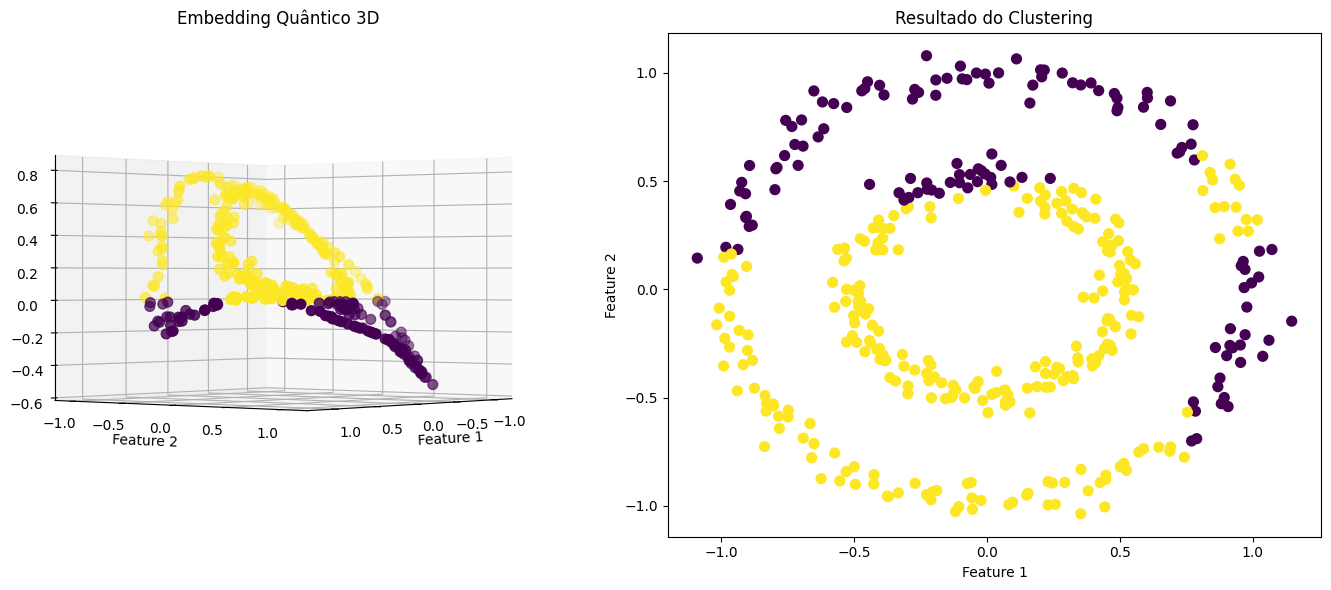

In [92]:
# Cálculo final das expectativas
expectativas_finais = np.array([circuito(x, params) for x in X_scaled])
# Atribuir clusters com base nas expectativas
continuous_preds = 2 / (1 + np.exp(-expectativas_finais)) - 1
# rotulos_preditos = np.sign([0 if e <= limiar else 1 for e in expectativas_finais])

# Plotar resultados
fig = plt.figure(figsize=(14, 6))

# Plot 3D do embedding
ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(X[:,0], X[:,1], expectativas_finais, 
                c=continuous_preds>0, cmap='viridis', s=50)
ax1.set_title("Embedding Quântico 3D")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Expectativa Z")
ax1.view_init(elev=0, azim=40)

# Plot do resultado do clustering
ax2 = fig.add_subplot(122)
ax2.scatter(X[:,0], X[:,1], c=continuous_preds>0, cmap='viridis', s=50)
ax2.set_title("Resultado do Clustering")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

Step 0: Cost = 0.1266
Step 10: Cost = 0.1278
Step 20: Cost = 0.1281
Step 30: Cost = 0.1278
Step 40: Cost = 0.1269
Step 50: Cost = 0.1275
Step 60: Cost = 0.1282
Step 70: Cost = 0.1268
Step 80: Cost = 0.1275
Step 90: Cost = 0.1269


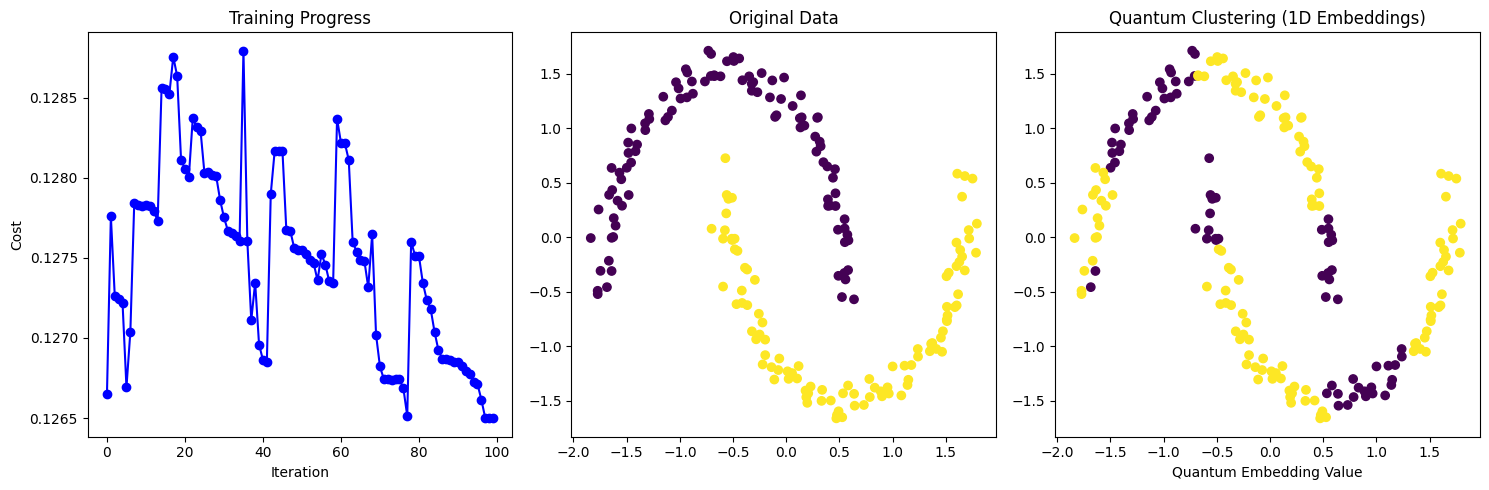


Silhouette Score: 0.63
Cluster Distribution: [ 72 128]


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import silhouette_score
from pennylane.optimize import SPSAOptimizer

# =============================================
# 1. Configuração do Circuito Quântico
# =============================================
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(weights, x):
    # Codificação dos dados
    for i in range(n_qubits):
        qml.RY(x[i] * np.pi, wires=i)
    
    # Camadas variacionais
    qml.StronglyEntanglingLayers(weights=weights, wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

# =============================================
# 2. Função de Custo com Kernel Quântico
# =============================================
def quantum_kernel_cost(weights, features, gamma=0.5, n_clusters=2):
    # Gerar embeddings quânticos
    embeddings = np.array([quantum_circuit(weights, x) for x in features])
    
    # Calcular matriz de kernel RBF
    n = len(features)
    kernel_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            diff = embeddings[i] - embeddings[j]
            kernel_matrix[i, j] = np.exp(-gamma * (diff ** 2))
    
    # Kernel K-Means Loss
    intra_cluster_loss = 0.0
    for k in range(n_clusters):
        # Selecionar pontos do cluster k (aproximação diferenciável)
        mask = (embeddings - np.mean(embeddings)) > (-1 if k == 0 else 0)  # Divisão adaptativa
        cluster_points = embeddings[mask]
        
        if len(cluster_points) > 0:
            # Variância intra-cluster via kernel
            mean_sim = np.mean(kernel_matrix[mask][:, mask])
            intra_cluster_loss += np.sum(1 - mean_sim)
    
    return intra_cluster_loss / n_clusters

# =============================================
# 3. Geração de Dados e Parâmetros Iniciais
# =============================================
# Dados sintéticos
features, true_labels = make_moons(n_samples=200, noise=0.05, random_state=42)

# Normalização
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Parâmetros iniciais do circuito
weights = np.random.rand(3, n_qubits, 3)  # 3 camadas
opt = SPSAOptimizer(100)

# =============================================
# 4. Loop de Treinamento
# =============================================
cost_history = []
best_weights = weights
best_cost = float('inf')

for step in range(100):
    # Calcular custo e atualizar parâmetros
    weights, cost = opt.step_and_cost(
        lambda w: quantum_kernel_cost(w, features), 
        weights
    )
    
    cost_history.append(cost)
    
    # Manter melhores pesos
    if cost < best_cost:
        best_cost = cost
        best_weights = np.copy(weights)
    
    if step % 10 == 0:
        print(f"Step {step}: Cost = {cost:.4f}")

# =============================================
# 5. Cluster Assignment Pós-Treinamento
# =============================================
# Gerar embeddings finais
final_embeddings = np.array([quantum_circuit(best_weights, x) for x in features])

# K-Means clássico nos embeddings quânticos
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(final_embeddings.reshape(-1,1))
cluster_assignments = kmeans.labels_

# =============================================
# 6. Visualização e Métricas
# =============================================
plt.figure(figsize=(15,5))

# Plot do histórico de custo
plt.subplot(1,3,1)
plt.plot(cost_history, 'b-o')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Training Progress")

# Plot dos dados originais
plt.subplot(1,3,2)
plt.scatter(features[:,0], features[:,1], c=true_labels, cmap='viridis')
plt.title("Original Data")

# Plot dos clusters quânticos
plt.subplot(1,3,3)
plt.scatter(features[:,0], features[:,1], c=cluster_assignments, cmap='viridis')
plt.title("Quantum Clustering (1D Embeddings)")
plt.xlabel("Quantum Embedding Value")

plt.tight_layout()
plt.show()

# Métricas
print(f"\nSilhouette Score: {silhouette_score(final_embeddings.reshape(-1,1), cluster_assignments):.2f}")
print(f"Cluster Distribution: {np.bincount(cluster_assignments)}")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Gerar dataset "moons" com ruído
X, y_true = make_moons(n_samples=500, noise=0.1, random_state=42)

def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

def kernel_distance(X, Z, gamma, cluster_assignments):
    n_samples = X.shape[0]
    n_clusters = np.unique(cluster_assignments).size
    distances = np.zeros((n_samples, n_clusters))
    
    for k in range(n_clusters):
        mask = (cluster_assignments == k)
        N_k = np.sum(mask)
        
        # Termo 1: K(x_i, x_i)
        term1 = rbf_kernel(X, X, gamma).diagonal()
        
        # Termo 2: -2/N_k * sum(K(x_i, x_j))
        term2 = -2/N_k * np.array([np.sum([rbf_kernel(X[i], X[j], gamma) for j in np.where(mask)[0]]) for i in range(n_samples)])
        
        # Termo 3: 1/N_k² * sum(K(x_j, x_l))
        term3 = 1/(N_k**2) * np.sum(rbf_kernel(X[mask], X[mask], gamma))
        
        distances[:, k] = term1 + term2 + term3
    
    return distances

def kernel_kmeans_optimized(X, n_clusters=2, max_iter=100, tol=1e-4, learning_rate=0.1, gamma_init=1.0):
    # Inicialização
    gamma = gamma_init
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(X)
    
    for _ in range(max_iter):
        # Passo 1: Calcular distâncias no espaço de características
        distances = kernel_distance(X, X, gamma, cluster_assignments)
        
        # Passo 2: Atualizar clusters
        new_assignments = np.argmin(distances, axis=1)
        
        # Critério de parada
        if np.sum(new_assignments != cluster_assignments) == 0:
            break
        cluster_assignments = new_assignments
        
        # Passo 3: Calcular gradiente e atualizar gamma (simplificado)
        # (Implementação simplificada do gradiente para exemplo)
        gamma += learning_rate * (np.mean(distances) - gamma)  # Ajuste heurístico
        
    return cluster_assignments, gamma

kmeans_standard = KMeans(n_clusters=2, random_state=42)
y_pred_standard = kmeans_standard.fit_predict(X)

y_pred_kernel, gamma_optimized = kernel_kmeans_optimized(X, gamma_init=10.0)
print(f"Gamma otimizado: {gamma_optimized:.2f}")

plt.figure(figsize=(12, 5))

# Plot K-Means Tradicional
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_standard, cmap='viridis', edgecolors='k')
plt.title(f"K-Means Tradicional\nARI: {adjusted_rand_score(y_true, y_pred_standard):.2f}")

# Plot K-Means com Kernel
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_kernel, cmap='viridis', edgecolors='k')
plt.title(f"K-Means com Kernel (Gamma={gamma_optimized:.2f})\nARI: {adjusted_rand_score(y_true, y_pred_kernel):.2f}")

plt.show()

ValueError: diag requires an array of at least two dimensions

In [7]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Configurações
n_qubits = 2  # Número de qubits
n_clusters = 2 # Número de clusters
n_samples = 20 # Número de dados

# Gerar dados de exemplo
data, _ = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=2, random_state=42)
data = np.array(data, requires_grad=False)

# Inicializar parâmetros variacionais
params = np.random.uniform(0, 2*np.pi, size=(2, n_qubits), requires_grad=True)

# Dispositivo quântico
dev = qml.device("default.qubit", wires=n_qubits)

# Circuito de embedding quântico
@qml.qnode(dev)
def quantum_embedding(x, params):
    # Codificar dados
    for i in range(n_qubits):
        qml.RX(x[i % len(x)], wires=i)
    # Camada variacional
    for i in range(n_qubits):
        qml.RY(params[0][i], wires=i)
    qml.CNOT(wires=[0, 1])
    # Medir sobreposição com o estado de referência (|00...0>)
    return qml.probs(wires=range(n_qubits))

# Calcular estados quânticos de todos os pontos
def compute_states(data, params):
    return np.array([quantum_embedding(x, params) for x in data])

# Função de custo: Distância intra-cluster média
def cost(params, data):
    # Obter estados quânticos
    states = compute_states(data, params)
    
    # Clusterização clássica nos estados (K-means)
    kmeans = KMeans(n_clusters=n_clusters).fit(states)
    labels = kmeans.labels_
    
    # Calcular centroides (média dos estados em cada cluster)
    centroids = []
    for c in range(n_clusters):
        cluster_states = states[labels == c]
        centroid = np.mean(cluster_states, axis=0)
        centroids.append(centroid)
    
    # Calcular distância média intra-cluster (1 - sobreposição)
    loss = 0
    for i, state in enumerate(states):
        c = labels[i]
        # Sobreposição entre o estado e o centroide
        overlap = np.dot(state, centroids[c])
        loss += (1 - overlap)
    
    return loss / len(data)

# Otimização
opt = qml.GradientDescentOptimizer(stepsize=0.1)
for epoch in range(50):
    params, prev_cost = opt.step_and_cost(cost, params, data)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Custo = {prev_cost:.4f}")

# Clusterização final com os parâmetros treinados
final_states = compute_states(data, params)
kmeans_final = KMeans(n_clusters=n_clusters).fit(final_states)
print("\nRótulos finais:", kmeans_final.labels_)

TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable conjugate method